In [1]:
# [RDKitで天然物らしさをスコア化して化合物ライブラリーの指標にする | 化学の新しいカタチ](https://future-chem.com/rdkit-np-likeness/)
# https://future-chem.com/rdkit-np-likeness/

In [17]:
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors

import pickle
import itertools

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn 

In [3]:
# import another library ./mylib/npscorer.py
# npscorer.py was got from https://github.com/rdkit/rdkit/tree/master/Contrib/NP_Score
from mylib import npscorer

In [4]:
# original web site used some sdf from ZINC-15, but I used platinum dataset
data = PandasTools.LoadSDF('./sdf/platinum_dataset_2017_01.sdf')
df = data[:450]
len(df)

450

In [5]:
### read pickle
with open('./mylib/publicnp.model', 'rb') as f:
    fs = pickle.load(f)



In [6]:
### calculate NP-likeness
# fs_scores = [npscorer.scoreMol(m, fs) for m in df.ROMol]
# df['np-likeness'] = fs_scores

fs_scores = [npscorer.scoreMol(m, fs) for m in df.ROMol]
df['np-likeness'] = fs_scores

/Users/yk/.pyenv/versions/anaconda3-5.3.1/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


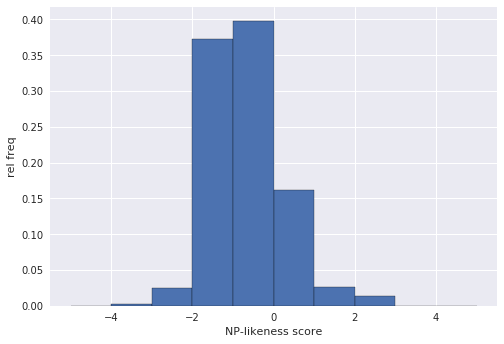

In [15]:
### create histgram
with mpl.style.context('seaborn'):
    plt.hist(fs_scores, density=True, bins=range(-5,6), ec="k")
    plt.xlabel('NP-likeness score')
    plt.ylabel('rel freq')



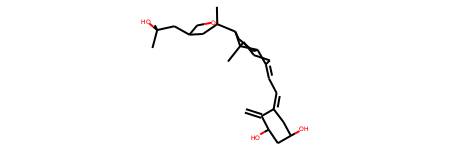

In [16]:
### get molecule which is biggest score
df.ROMol[df['np-likeness'].idxmax()]

/Users/yk/.pyenv/versions/anaconda3-5.3.1/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yk/.pyenv/versions/anaconda3-5.3.1/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yk/.pyenv/versions/anaconda3-5.3.1/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: Se

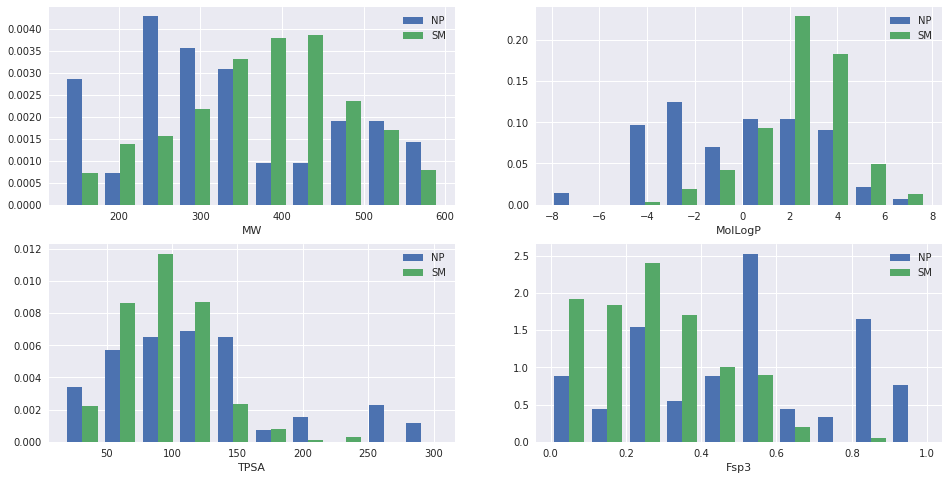

In [19]:
### calculate descriptor
df['MolLogP'] = df.ROMol.map(Descriptors.MolLogP)
df['MW'] = df.ROMol.map(Descriptors.MolWt)
df['TPSA'] = df.ROMol.map(Descriptors.TPSA)
df['Fsp3'] = df.ROMol.map(Descriptors.FractionCSP3)

### case by score, positive or negative
df_np = df[df['np-likeness'] >= 0]
df_sm = df[df['np-likeness'] < 0]

### create histgram for each descriptor
descs = ['MW', 'MolLogP', 'TPSA', 'Fsp3']
with mpl.style.context('seaborn'):
    fig, ax = plt.subplots(2,2, figsize=(16,8))
    for (i, j), desc in zip(itertools.product(range(2), range(2)), descs):
        ax[i,j].hist([df_np[desc], df_sm[desc]], density=True, label=['NP', 'SM'])
        ax[i,j].set_xlabel(desc)
        ax[i,j].legend(loc='best')

In [21]:
df_np[df_np.ROMol >= Chem.MolFromSmiles('OP(O)(=O)O')]['MolLogP'].describe().round(2)

count    21.00
mean     -2.84
std       1.86
min      -8.05
25%      -4.01
50%      -2.62
75%      -1.78
max       1.31
Name: MolLogP, dtype: float64

In [22]:
df_sm[df_sm.ROMol >= Chem.MolFromSmiles('OP(O)(=O)O')]['MolLogP'].describe().round(2)

count    2.00
mean    -1.41
std      2.29
min     -3.03
25%     -2.22
50%     -1.41
75%     -0.60
max      0.21
Name: MolLogP, dtype: float64